# Flower classification model training notebook
In this notebook we finetune a model to classify flowers

In [1]:
import os
from os.path import join as opj
import shutil
from collections import Counter
from datetime import datetime

In [2]:
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tqdm.autonotebook import tqdm
import splitfolders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_utils import freeze_backbone, modify_clsf_head
from train import train_model, plot_training_results, get_test_predicts, get_test_metrics

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
RANDOM_SEED = 777
BATCH_SIZE = 64

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

# 1. Download and prepare Data

## 1.1 Download dataset
Download dataset from kaggle and visualise some samples

In [4]:
def visualise_samples(dataset, samples_per_class=5, title="Dataset samples"):
    fig, axes = plt.subplots(samples_per_class, len(dataset.classes), figsize=(15, samples_per_class * 2))
    fig.suptitle(title, fontsize=15)
    axes = axes
    for i in range(0, len(dataset.classes)):
        idxs = np.where(np.array(dataset.targets) == i)[0]
        for j, idx in enumerate(idxs[:samples_per_class]):
            if j == 0:
                axes[j][i].set_title(idx_to_class[i], fontsize=10)
            axes[j][i].imshow(dataset[idx][0])
            axes[j][i].axis('off')
    plt.show()

In [5]:
base_path = kagglehub.dataset_download('alxmamaev/flowers-recognition')
dataset_dir = opj(base_path, "flowers")
dataset = ImageFolder(dataset_dir)

idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}
targets_names = [idx_to_class[v] for v in dataset.targets]
targets = np.array(dataset.targets)
n_classes = len(dataset.classes)

Dataset summary:
 4317 samples
 * daisy: 764 samples (17%)
 * dandelion: 1052 samples (24%)
 * rose: 784 samples (18%)
 * sunflower: 733 samples (16%)
 * tulip: 984 samples (22%)


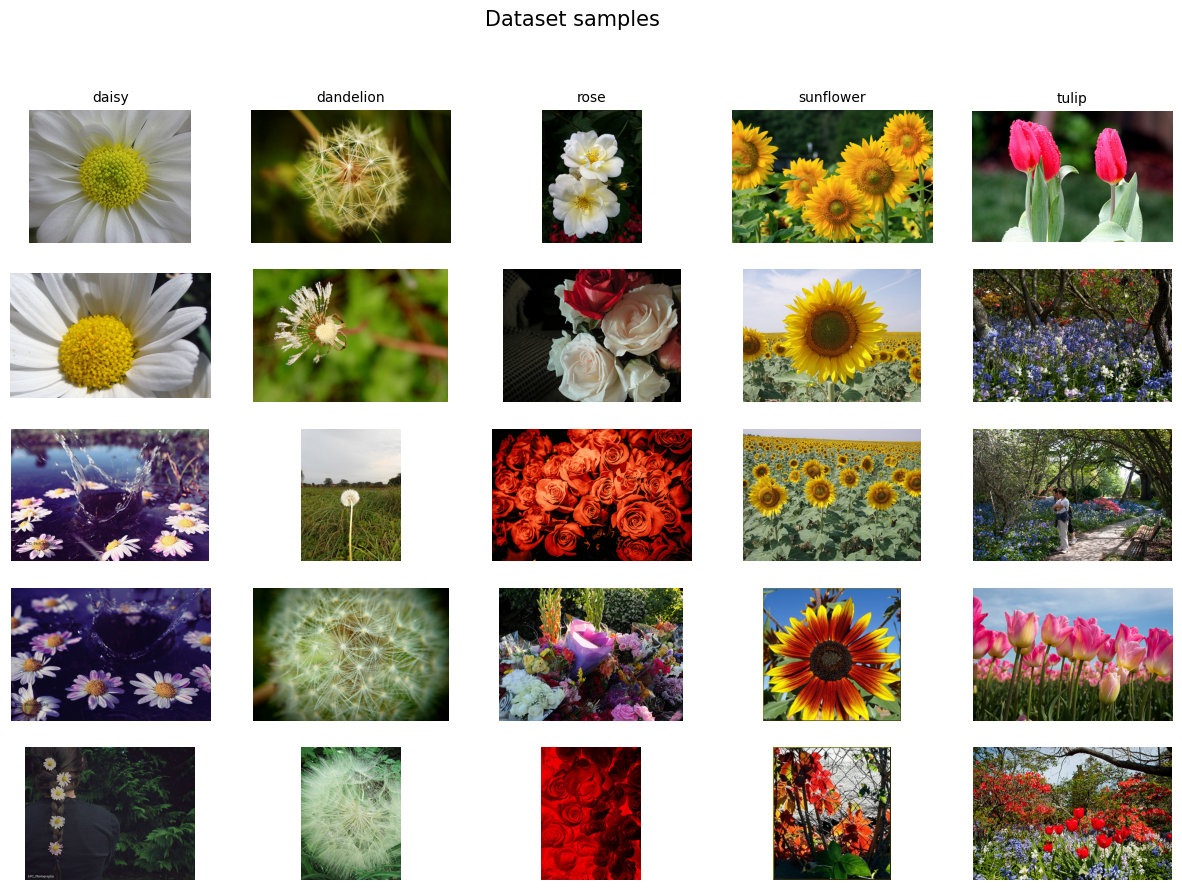

In [6]:
print(f"Dataset summary:\n {len(dataset)} samples")
for k, v in Counter(dataset.targets).items():
    print (f" * {idx_to_class[k]}: {v} samples ({int(100 * v / len(dataset))}%)")
    
visualise_samples(dataset)

## 1.2 Train/test/val split

In [7]:
splitted_path = './data/flowers'
splitfolders.ratio(
    input=dataset_dir, output=splitted_path, seed=RANDOM_SEED, ratio=(0.7, 0.15, 0.15)
)

Copying files: 4317 files [00:05, 843.44 files/s] 


In [8]:
train_ds = ImageFolder(opj(splitted_path, "train"))
val_ds = ImageFolder(opj(splitted_path, "val"))
test_ds = ImageFolder(opj(splitted_path, "test"))
class_distribution = {}

for ds, split_name in zip((train_ds, val_ds, test_ds), ("train", "test", "val")):
    split_count = Counter(ds.targets)
    total_samples = sum(split_count.values())
    class_distribution[split_name] = {}
    for idx, count in split_count.items():
        class_distribution[split_name][idx_to_class[idx]] = \
            f"{count} ({int(100 * count / total_samples)}%)"
    class_distribution[split_name]["total"] = total_samples

class_distribution_df = pd.DataFrame(class_distribution).T
class_distribution_df

,daisy,dandelion,rose,sunflower,tulip,total
train,534 (17%),736 (24%),548 (18%),513 (16%),688 (22%),3019
test,114 (17%),157 (24%),117 (18%),109 (16%),147 (22%),644
val,116 (17%),159 (24%),119 (18%),111 (16%),149 (22%),654


In [9]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=True
)

### 1.3 Add augmentations

In [10]:
augmentations = v2.Compose([
    v2.RandomRotation(degrees=(0, 15)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0))
])

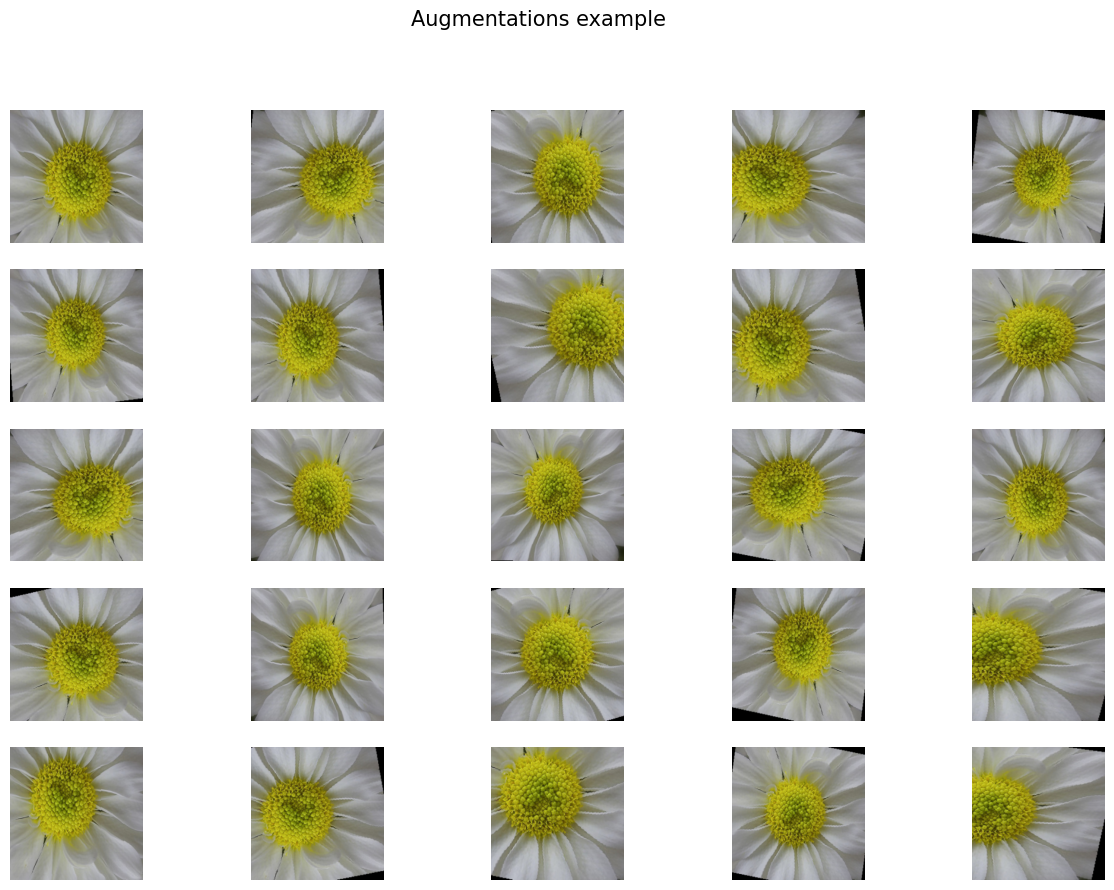

In [11]:
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
fig.suptitle("Augmentations example", fontsize=15)
axes = axes.flatten()
dataset.transform = augmentations
for i in range(len(axes)):
    axes[i].imshow(dataset[0][0])
    axes[i].axis('off')

### 1.4 Create dataloaders

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False
)

# 2. Train models

In [13]:
from torchvision.models import regnet_x_800mf, RegNet_X_800MF_Weights
weights = RegNet_X_800MF_Weights.DEFAULT
regnetx_transforms = weights.transforms()
val_ds.transform = regnetx_transforms
test_ds.transform = regnetx_transforms
train_ds.transform = v2.Compose([augmentations, regnetx_transforms])

In [14]:
# Freezed backbone
regnetx_freeze = regnet_x_800mf(weights=weights)
regnetx_freeze = modify_clsf_head(regnetx_freeze, n_classes)
regnetx_freeze = freeze_backbone(regnetx_freeze)
regnetx_freeze.to(device)
regnetx_freeze, freeze_metrics = train_model(regnetx_freeze, train_loader, val_loader, epochs=10, device=device)
plot_training_results(freeze_metrics['train_accs'],
                    freeze_metrics['train_losses'],
                    freeze_metrics['val_accs'],
                    freeze_metrics['val_losses'])

NameError: name 'modify_clsf_head' is not defined

In [ ]:
# Unfreezed backbone
weights = RegNet_X_800MF_Weights.DEFAULT
regnetx_unfreeze = regnet_x_800mf(weights=weights)
regnetx_unfreeze = modify_clsf_head(regnetx_unfreeze)
regnetx_unfreeze.to(device)
regnetx_unfreeze, unfreeze_metrics = train_model(regnetx_unfreeze, train_loader, val_loader, epochs=10, device=device)
plot_training_results(unfreeze_metrics['train_accs'],
                    unfreeze_metrics['train_losses'],
                    unfreeze_metrics['val_accs'],
                    unfreeze_metrics['val_losses'])

In [ ]:
get_test_metrics(regnetx_freeze, "freezed backbone", test_loader, device=device)

In [ ]:
get_test_metrics(regnetx_unfreeze, "unfreezed backbone", test_loader, device=device)

In [ ]:
model_save_path = './weights/backbone.pth'
regnetx_unfreeze.fc[-1] = nn.Identity()
torch.save(regnetx_unfreeze.state_dict(), model_save_path)

# 3. Similarity Search

In [ ]:
embeddings = []

for image, _ in test_loader:
    

In [ ]:
test_ds.samples

# 4. Convert to ONNX